In [1]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.4)

from google_drive_downloader import GoogleDriveDownloader as gdd

import time

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


device(type='cuda', index=0)

In [2]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [3]:
data_transforms = {
    'trainset': transforms.Compose([
        transforms.RandomResizedCrop(496), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'testset': transforms.Compose([
        transforms.Resize(512), 
        transforms.CenterCrop(496), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/datasets/neuro_woods'

trainset = datasets.ImageFolder(os.path.join(data_dir, 'trainset'), transform=data_transforms['trainset'])
testset = ImageFolderWithPaths(os.path.join(data_dir, 'testset'), transform=data_transforms['testset'])
class_names = trainset.classes

class_names

['1_resized', '3_resized', 'drova_resized']

In [4]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [5]:
val_size = 0.2
val_inds = subset_ind(trainset, val_size)

train_dataset = torch.utils.data.Subset(trainset, [i for i in range(len(trainset)) if i not in val_inds])
val_dataset = torch.utils.data.Subset(trainset, val_inds)
dataset_sizes = {dataset_name: len(dataset) for dataset_name, dataset in zip(['train', 'val'], [train_dataset, val_dataset])}
use_gpu = torch.cuda.is_available()

print('train size - {}\nval size - {}'.format(dataset_sizes['train'], dataset_sizes['val']))

train size - 462
val size - 115


In [6]:
batch_size=4

dataloaders = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               shuffle=True, num_workers=2), 
               'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                             shuffle=False, num_workers=2)
              }

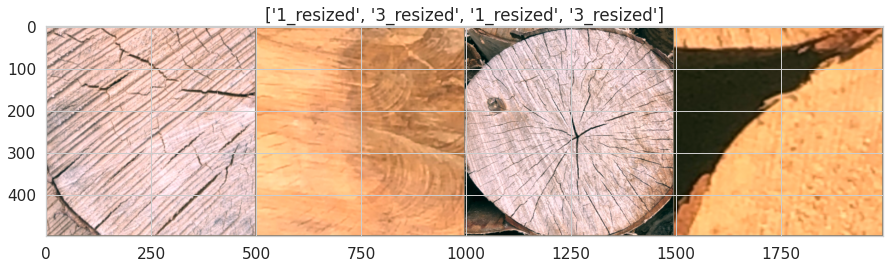

In [7]:
def imshow(input, title=None):
  input = input.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.299, 0.224, 0.225])
  input = std * input + mean
  input = np.clip(input, 0, 1)

  plt.figure(figsize=(15, 12))
  plt.imshow(input)

  if title is not None:
    plt.title(title)

  plt.pause(0.001)


images = next(iter(dataloaders['train']))
inputs, classes = images
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def fit(model, criterion, optimizer, scheduler, epochs=25):
    '''

    основной код тренировки

    '''
    start = time.time()
  
    best_mode_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    pbar = trange(epochs)

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()

            curr_loss = 0.0
            curr_corrects = 0  

            for data in tqdm(dataloaders[phase], leave=False, desc=f'{phase} iteration'):
                inputs, labels = data
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                
                if phase == 'train':
                    optimizer.zero_grad()

                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                curr_loss += loss.item()
                curr_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = curr_loss / dataset_sizes[phase]
            epoch_acc = curr_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            pbar.set_description(f'{phase} loss: {epoch_loss:.4f} accuracy: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
  
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print(f'Best validation accuracy: {best_acc:.4f}')

    # загружаем лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [9]:
def evaluate(model):
    '''

    измеряет точность модели на валидационном датасете

    '''

    model.eval()

    curr_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data

        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        output = model(inputs)
        _, preds = torch.max(output, 1)

        curr_correct += int(torch.sum(preds == labels))

    return curr_correct / dataset_sizes['val']

In [10]:
resnet = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [12]:
for param in resnet.parameters():
    param.require_grad = False

num_features = 25008
resnet.classifier = nn.Linear(num_features, 3)

if use_gpu:
    resnet = resnet.cuda()

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [ ]:
resnet, resnet_losses, resnet_accuracies = fit(resnet, loss_func, optimizer, lr_scheduler, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

train iteration:   0%|          | 0/116 [00:00<?, ?it/s]

val iteration:   0%|          | 0/29 [00:00<?, ?it/s]

train iteration:   0%|          | 0/116 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
plt.plot(resnet_losses['train'], label='train')
plt.plot(resnet_losses['val'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_accuracies['train'], label='train')
plt.plot(resnet_accuracies['val'], label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [ ]:
count_true = 0

with torch.no_grad():
  for data in dataloaders['val']:
    images, labels = data
    y_pred = resnet(images.to(device))
    _, predicted = torch.max(y_pred, 1)

    c = predicted.cpu().detach() == labels
    
    for i in range(len(c)):
        count_true += 1 if c[i].item() == True else 0
    
print('accuracy on val set - {:.4f}'.format(count_true / (len(dataloaders['val'])*batch_size)))

In [23]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, pin_memory=True, num_workers=2)

real = []
pred = []

with torch.no_grad():
    metrics = []
    for batch in tqdm(test_loader):
        x, y, _ = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = resnet(x)

        y_true = y.detach().cpu().numpy().tolist() 
        y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis=1).tolist()
        pred.extend(y_pred)

print(pred)

  0%|          | 0/249 [00:00<?, ?it/s]

[2, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 2, 0, 1, 2, 1, 0, 1, 0, 1, 1, 2, 1, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 0, 1, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1]


In [24]:
import pandas as pd

a = np.array([list(range(1, 250)), pred]).T
submission = pd.DataFrame(a, columns=['id', 'class'])
submission.to_csv('./submission.csv', index=False)

In [25]:
submission.head()

,id,class
0,1,2
1,2,0
2,3,1
3,4,2
4,5,1
